In [106]:
import rul_datasets
import rul_adapt
import numpy as np
import matplotlib.pyplot as plt

In [107]:
def horizontal(x):
    return x[:, :, 0, None]

def norm(x):
    return np.linalg.norm(x, axis=2, keepdims=True)


def get_threshold(runs, transform, deadtime):
    threshs = []
    for r in runs:
        kurt = rul_adapt.approach.tbigru.kurtosis(transform(r[:deadtime]))
        threshs.append((np.mean(kurt), np.std(kurt)))

    return threshs


def get_deadtime(runs):
    return int(np.mean([x.shape[0] for x in runs]) * 0.2)


def get_fttp(runs, threshs, deadtime=0, transform=horizontal):
    return [_get_fttp_for_run(r, thresh, deadtime, transform) for r, thresh in zip(runs, threshs)]


def _get_fttp_for_run(r, thresh, deadtime, transform):
    mean, std = thresh
    deadtime = len(r) // 10 if deadtime > len(r) // 2 else deadtime
    indicator = np.abs(rul_adapt.approach.tbigru.kurtosis(transform(r[deadtime:])) - mean) > 2*std
    two_in_a_row = np.convolve(indicator.squeeze(), [1, 1])

    if np.max(two_in_a_row) >= 2:
        return np.argmax(two_in_a_row) + deadtime
    else:
        return deadtime


def plot_fttp(runs, fttps, deadtime=0, transform=horizontal):
    for i, (r, fttp) in enumerate(zip(runs, fttps)):
        plt.yscale("log")
        plt.plot(rul_adapt.approach.tbigru.rms(transform(r)), alpha=0.5)
        plt.axvline(fttp, color=plt.get_cmap("tab10")(i))
    plt.xlabel("Time Step")
    plt.ylabel("RMS")
    plt.axvline(deadtime, color="green")

In [108]:
def get_dataset_fttp(reader, transform):
    reader.prepare_data()
    train, _ = reader.load_split("dev")
    val, _ = reader.load_split("val")
    test, _ = reader.load_split("test")

    patience = get_deadtime(train)
    train_thresh = get_threshold(train, transform, patience)
    train_fttp = get_fttp(train, train_thresh, patience, transform)
    print(f"Deadtime for getting initial kurtosis: {patience}")
    print(f"Training fttp: {train_fttp}")
    plot_fttp(train, train_fttp, patience, transform)
    plt.show()

    val_thresh = get_threshold(val, transform, patience)
    val_fttp = get_fttp(val, val_thresh, patience, transform)
    plot_fttp(val, val_fttp, patience, transform)
    print(f"Validation fttp: {val_fttp}")
    plt.show()

    test_thresh = get_threshold(test, transform, patience)
    test_fttp = get_fttp(test, test_thresh, patience, transform)
    plot_fttp(test, test_fttp, patience, transform)
    print(f"Test fttp: {test_fttp}")
    plt.show()

Deadtime for getting initial kurtosis: 367
Training fttp: [407, 544]


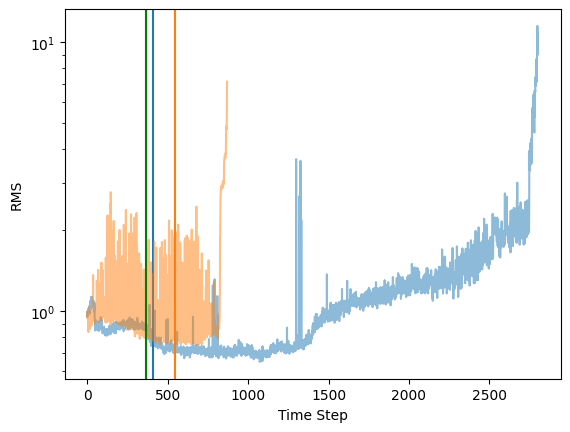

Validation fttp: [521]


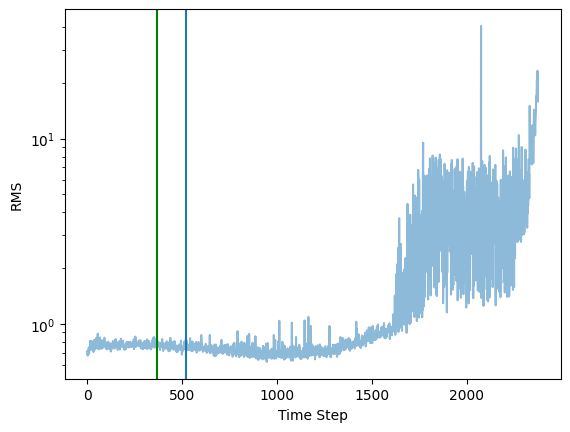

Test fttp: [840, 2306, 479, 995]


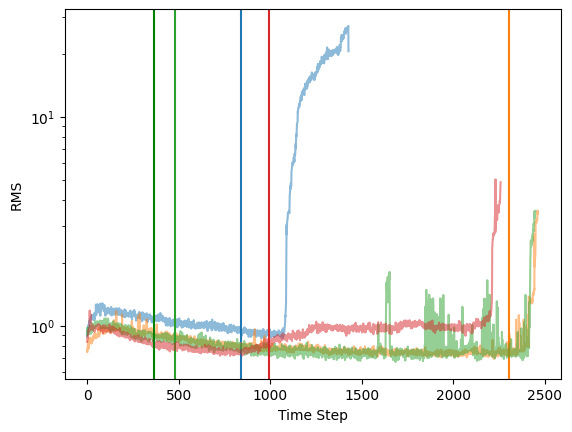

In [109]:
fd1 = rul_datasets.FemtoReader(fd=1)
get_dataset_fttp(fd1, transform=norm)
del fd1

Deadtime for getting initial kurtosis: 170
Training fttp: [819, 192]


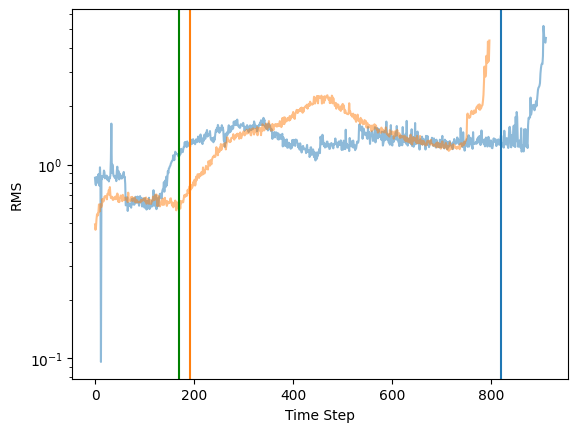

Validation fttp: [257]


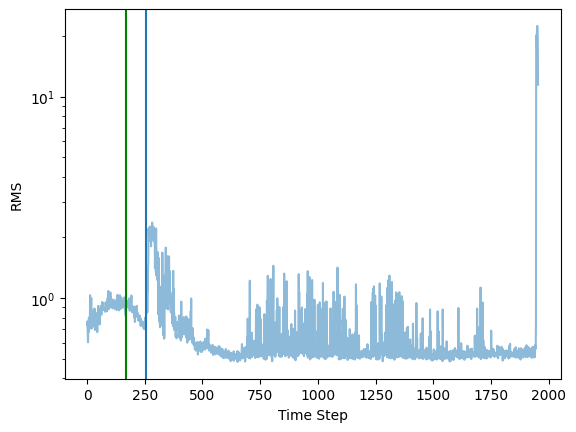

Test fttp: [248, 252, 213, 163]


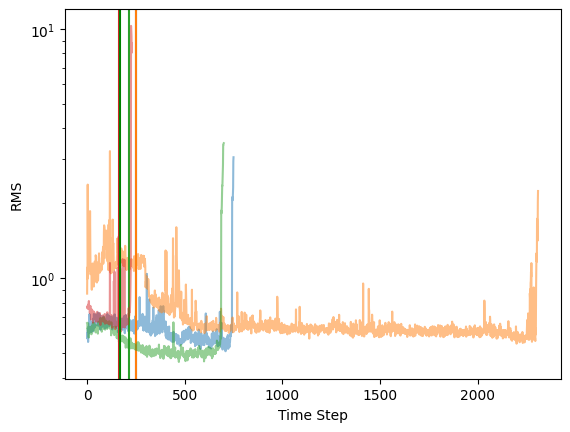

In [110]:
fd2 = rul_datasets.FemtoReader(fd=2)
get_dataset_fttp(fd2, transform=norm)
del fd2

Deadtime for getting initial kurtosis: 103
Training fttp: [132]


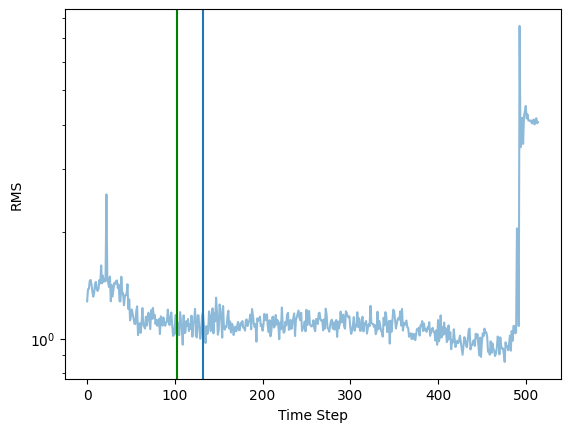

Validation fttp: [116]


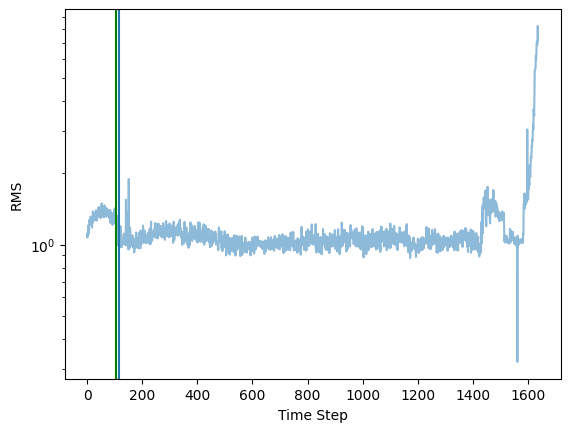

Test fttp: [306]


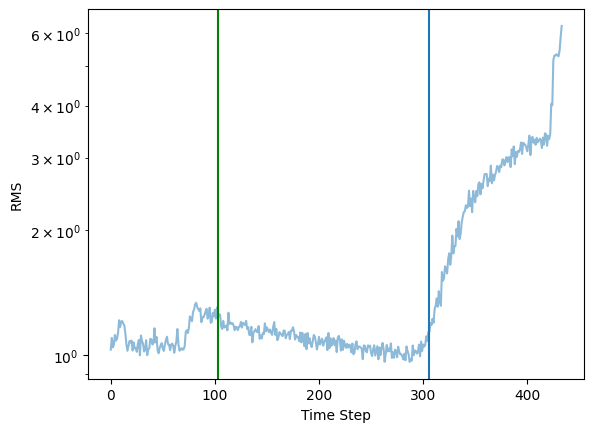

In [111]:
fd3 = rul_datasets.FemtoReader(fd=3)
get_dataset_fttp(fd3, transform=norm)
del fd3

Deadtime for getting initial kurtosis: 28
Training fttp: [28, 32]


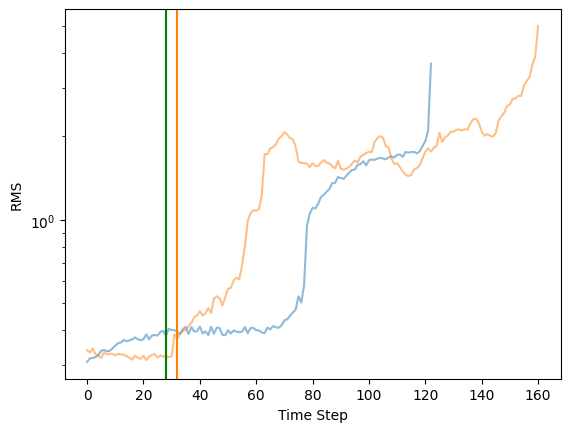

Validation fttp: [61]


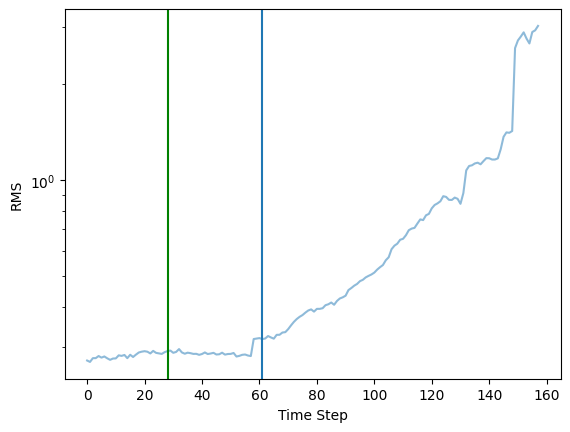

Test fttp: [52, 36]


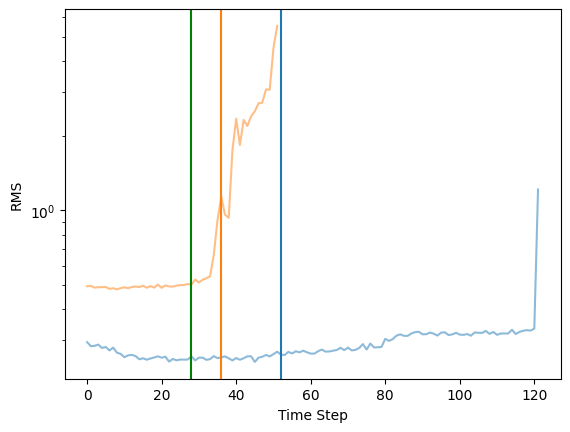

In [112]:
fd1 = rul_datasets.XjtuSyReader(fd=1)
get_dataset_fttp(fd1, transform=norm)
del fd1

Deadtime for getting initial kurtosis: 65
Training fttp: [238, 65]


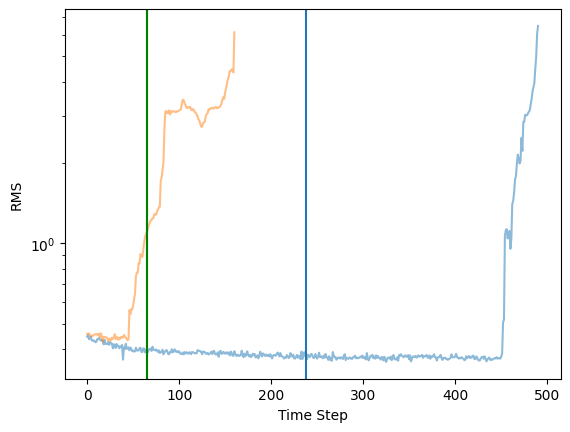

Validation fttp: [128]


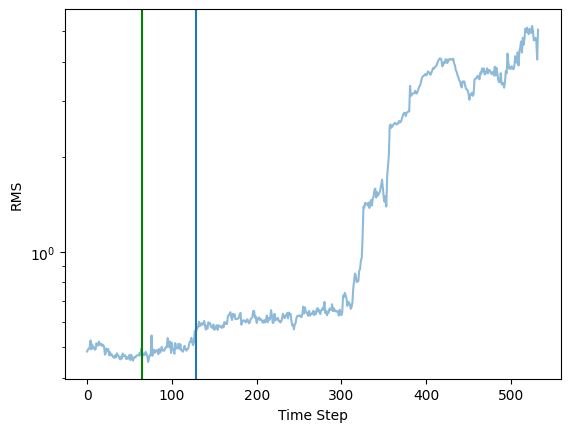

Test fttp: [4, 121]


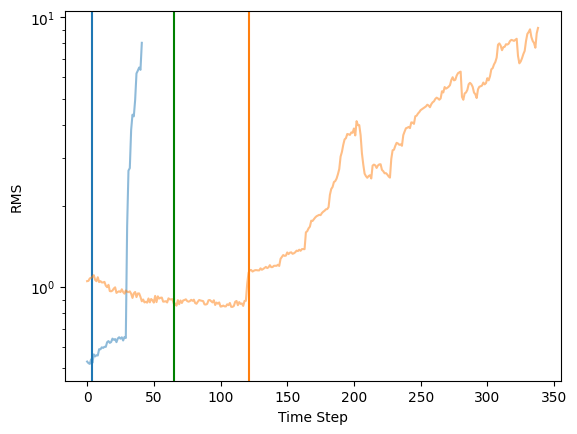

In [113]:
fd2 = rul_datasets.XjtuSyReader(fd=2)
get_dataset_fttp(fd2, transform=norm)
del fd2

Deadtime for getting initial kurtosis: 503
Training fttp: [749, 614]


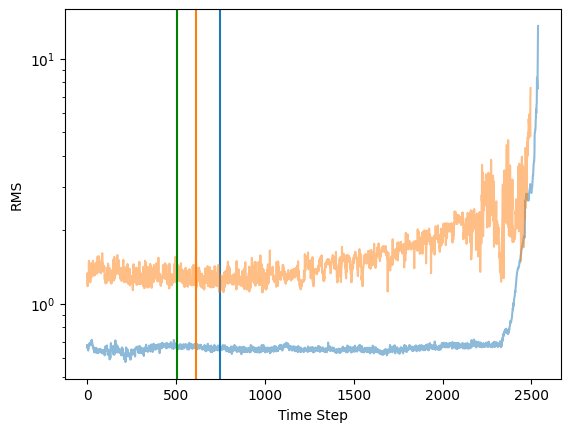

Validation fttp: [342]


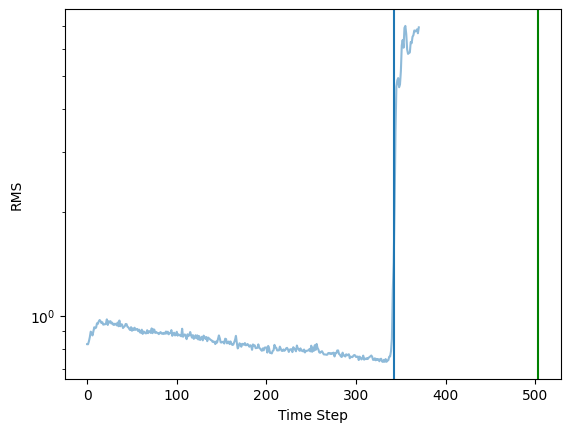

Test fttp: [1418, 74]


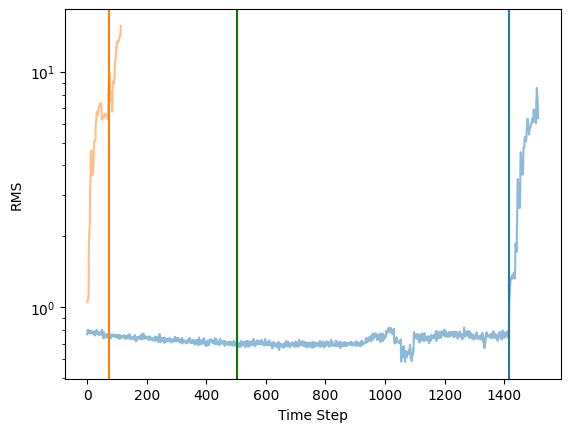

In [114]:
fd3 = rul_datasets.XjtuSyReader(fd=3)
get_dataset_fttp(fd3, transform=norm)
del fd3